# Question:

1. What does the standard deviation of correlation coefficient of PCs towards one target assets mean?


In this notebook, we have explored the concept of using the standard deviation of the correlation coefficient of principal components to filter out the robust principal components. We have demonstrated this approach using synthetic data.

The key steps of the approach are as follows:

1. Calculate the rolling correlation coefficient of the principal components with the test feature.
2. Compute the standard deviation of the correlation coefficient distribution for each principal component.
3. Filter out the principal components based on the 25% quantile of the standard deviation.
4. Apply a weighted smoothing technique to reduce the standard deviation of the correlation coefficient.
5. Evaluate the reduction in the standard deviation of the correlation coefficient to assess the robustness of the principal components.
6. Repeat the process for different test features and datasets to validate the approach.

## Constructing Data for PCA
### Feature Generation
Given the following features:

- $\text{Feature 1}$ is generated from a normal distribution:
  $$
  \text{Feature 1} \sim \mathcal{N}(0, 1)
  $$

- $\text{Feature 2}$ is linearly dependent on $\text{Feature 1}$ with some added noise:
  $$
  \text{Feature 2} = 2 \times \text{Feature 1} + \epsilon_2
  $$
  where $\epsilon_2 \sim \mathcal{N}(0, 1)$ (noise term).

- $\text{Feature 3}$ is a combination of $\text{Feature 1}$ and $\text{Feature 2}$ with added noise:
  $$
  \text{Feature 3} = 0.5 \times \text{Feature 1} + \text{Feature 2} + \epsilon_3
  $$
  where $\epsilon_3 \sim \mathcal{N}(0, 1)$ (noise term).

- $\text{Feature 4}$ is independently generated from a normal distribution:
  $$
  \text{Feature 4} \sim \mathcal{N}(0, 1)
  $$

- $\text{Feature 5}$ is dependent on $\text{Feature 4}$ with added noise:
  $$
  \text{Feature 5} = \text{Feature 4} + \epsilon_5
  $$
  where $\epsilon_5 \sim \mathcal{N}(0, 1)$ (noise term).



In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Set a random seed for reproducibility
np.random.seed(42)

# Generate fake data with 5 features and 100 samples
n_samples = 1000
feature_1 = np.random.normal(0, 1, n_samples)
feature_2 = 2 * feature_1 + np.random.normal(0, 1, n_samples)
feature_3 = 0.5 * feature_1 + feature_2 + np.random.normal(0, 1, n_samples)
feature_4 = np.random.normal(0, 1, n_samples)
feature_5 = feature_4 + np.random.normal(0, 1, n_samples)

# Create a DataFrame
data = pd.DataFrame({
    'Feature 1': feature_1,
    'Feature 2': feature_2,
    'Feature 3': feature_3,
    'Feature 4': feature_4,
    'Feature 5': feature_5
})

In [2]:
data.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5
0,0.496714,2.392784,1.965963,-1.907808,-2.771301
1,-0.138264,0.648105,0.434454,-0.860385,-0.891588
2,0.647689,1.355007,0.886432,-0.413606,-0.395589
3,1.523030,2.399123,2.852676,1.887688,2.360318
4,-0.234153,0.229917,-1.780775,0.556553,-0.810305


Text(0.5, 0, 'Sample Index')

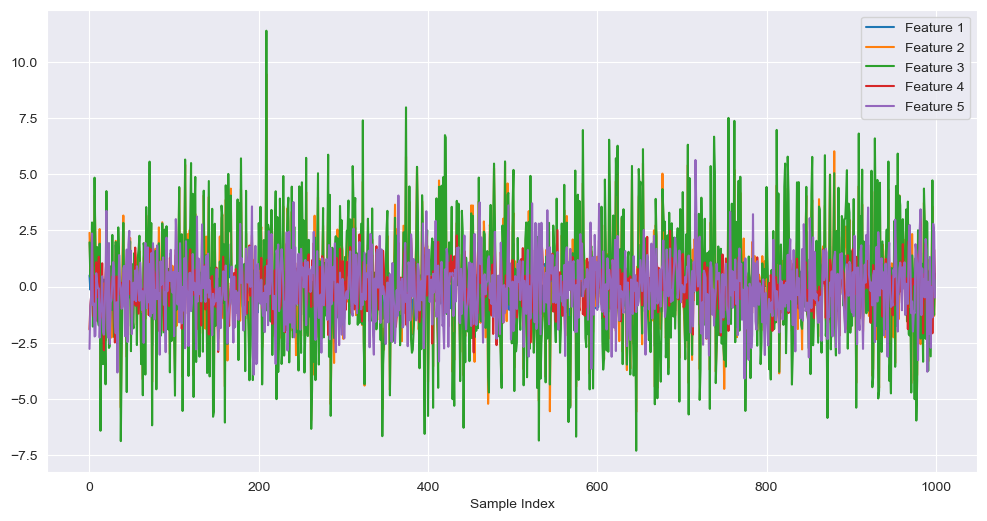

In [3]:
# plot the data as line plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data)
plt.legend(data.columns)
plt.xlabel('Sample Index')

In [4]:
# Apply PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(data)

# Explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for PCA result
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(5)])
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(5)],
    'Explained Variance Ratio': explained_variance
})

pca_df.head()


,PC1,PC2,PC3,PC4,PC5
0,2.950208,-3.245980,0.493701,-0.290750,-0.372233
1,0.541026,-1.140644,0.064548,-0.304510,-0.326701
2,1.483007,-0.466183,0.520777,-0.286451,0.138754
3,3.748316,3.153458,0.449700,0.223382,0.477991
4,-1.453400,-0.383032,1.397956,0.571109,-0.230584


In [5]:
explained_variance_df

,Principal Component,Explained Variance Ratio
0,PC1,0.776391
1,PC2,0.165804
2,PC3,0.024798
3,PC4,0.022567
4,PC5,0.010440


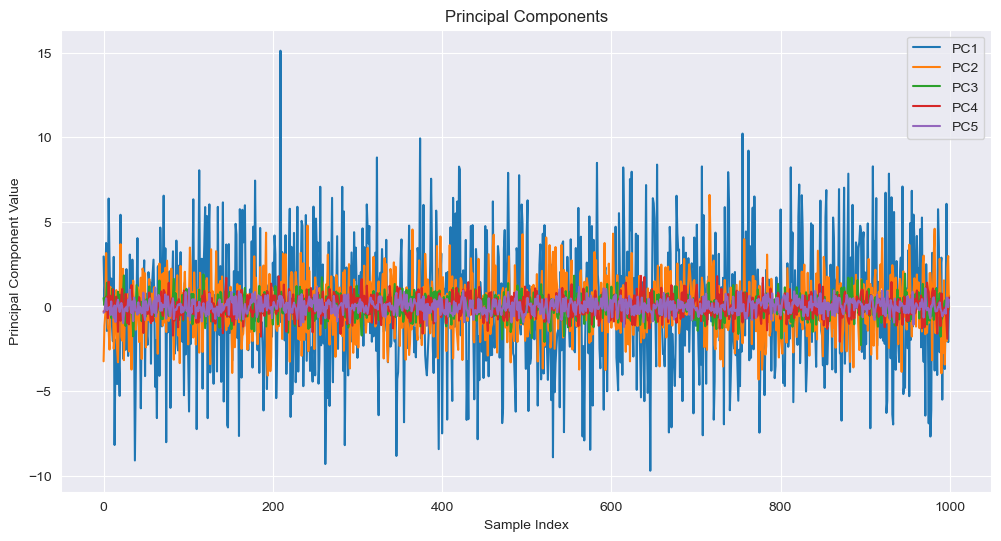

In [6]:
# Plot the PCs as line plot
plt.figure(figsize=(12, 6))

plt.plot(pca_df)
plt.legend(pca_df.columns)
plt.xlabel('Sample Index')
plt.ylabel('Principal Component Value')
plt.title('Principal Components')
plt.show()

# Correlation Matrix

Calculate the correlation matrix of the original features and the principal components.

In [7]:
# Correlation matrix of the original features
correlation_original = data.corr()
correlation_original

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5
Feature 1,1.000000,0.887366,0.867554,-0.013321,-0.030989
Feature 2,0.887366,1.000000,0.932258,-0.037309,-0.051991
Feature 3,0.867554,0.932258,1.000000,-0.023547,-0.031444
Feature 4,-0.013321,-0.037309,-0.023547,1.000000,0.725582
Feature 5,-0.030989,-0.051991,-0.031444,0.725582,1.000000


In [8]:
# Correlation matrix of the principal components
correlation_pca = pca_df.corr()
correlation_pca

,PC1,PC2,PC3,PC4,PC5
PC1,1.000000e+00,9.534685e-17,-3.212494e-16,1.090473e-16,2.439775e-15
PC2,9.534685e-17,1.000000e+00,7.535470e-17,-3.647588e-16,-1.077420e-16
PC3,-3.212494e-16,7.535470e-17,1.000000e+00,-3.615918e-16,1.176109e-15
PC4,1.090473e-16,-3.647588e-16,-3.615918e-16,1.000000e+00,-3.411679e-16
PC5,2.439775e-15,-1.077420e-16,1.176109e-15,-3.411679e-16,1.000000e+00


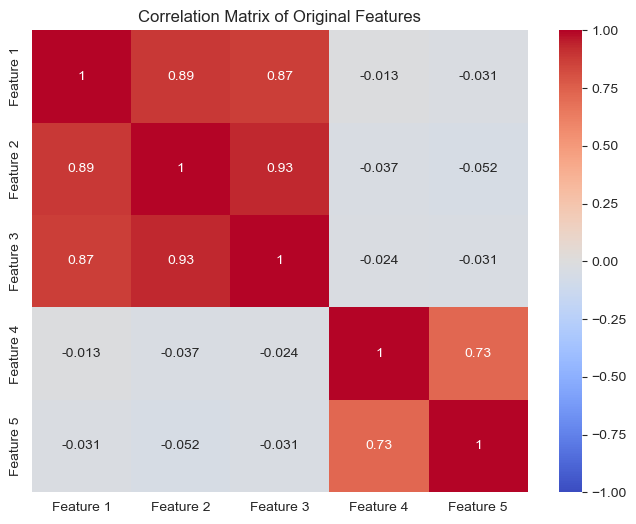

In [9]:
# Display the correlation matrix of the original features as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_original, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Original Features')
plt.show()

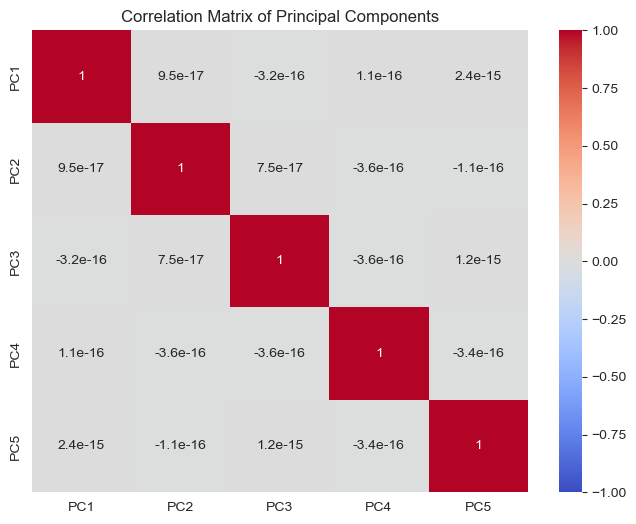

In [10]:
# Display the correlation matrix of the principal components as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_pca, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Principal Components')
plt.show()

### Generate Test Feature 

Now, let's generate a new feature that is Feature 1 itself. 

In [11]:
beta_mat = [1, 0, 0, 0, 0]

test_feature = data @ beta_mat
test_feature.name = 'Test Feature'

In [12]:
test_feature.head()

0    0.496714
1   -0.138264
2    0.647689
3    1.523030
4   -0.234153
Name: Test Feature, dtype: float64

In [13]:
# rolling-window correlation coefficient
def rolling_corr(df, window=10):
    return df.rolling(window).corr(pairwise=True).dropna()

In [14]:
test_data = data.copy()
test_data['Test Feature'] = test_feature

In [15]:
rolling_corr(test_data, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5
29,1.0,0.895190,0.883769,0.105453,0.049862
30,1.0,0.894835,0.880856,0.169933,0.104799
31,1.0,0.886959,0.868337,0.134962,0.019754
32,1.0,0.884788,0.866836,0.142626,0.016622
33,1.0,0.880848,0.857484,0.046016,-0.047356


<Axes: >

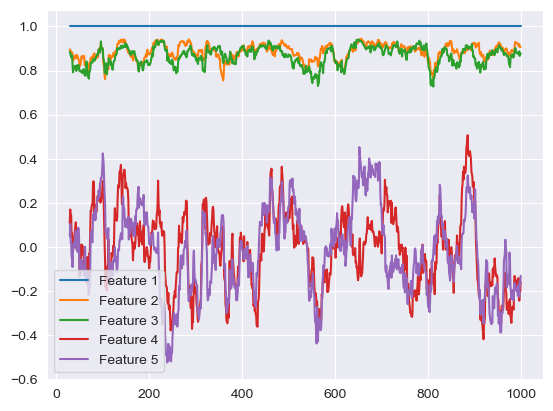

In [16]:
rolling_corr(test_data, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).plot()

This makes sense Feature 1 is perfectly correlated with the test feature, as the test feature is generated from Feature 1 itself.

Also, Feature2 and Feature3 are constructed from Feature1 as well, so they are highly correlated with the test feature.

Naturally, we see other features are less correlated with the test feature, as they are independent of Feature1.

In [17]:
rolling_corr(test_data, window=30)['Test Feature'].unstack().mean()

Feature 1       1.000000
Feature 2       0.884721
Feature 3       0.866381
Feature 4      -0.012049
Feature 5      -0.019443
Test Feature    1.000000
dtype: float64

In [18]:
data.corr()['Feature 1']

Feature 1    1.000000
Feature 2    0.887366
Feature 3    0.867554
Feature 4   -0.013321
Feature 5   -0.030989
Name: Feature 1, dtype: float64

### Rolling Correlation Coefficient of PCs (PCA Analysis)

In [19]:
target_w_pc = pca_df.copy()
target_w_pc['Test Feature'] = test_feature

In [20]:
rolling_corr_series = rolling_corr(target_w_pc, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1)
rolling_corr_series.head()

,PC1,PC2,PC3,PC4,PC5
29,0.922854,0.108064,0.130221,0.060262,0.454721
30,0.922614,0.170546,0.137266,0.091439,0.467262
31,0.913577,0.097781,0.185427,0.129100,0.570709
32,0.912105,0.098422,0.170952,0.146177,0.562790
33,0.907010,0.016940,0.163751,0.076122,0.530707


<Axes: >

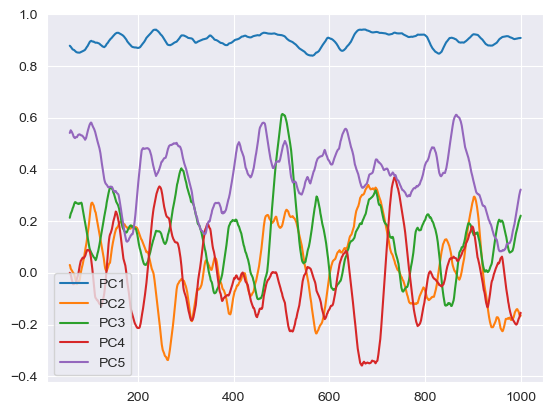

In [21]:
rolling_corr_series.rolling(30).mean().plot()

PC1 should be the most correlated with the test feature, as the test feature is generated from the first feature, which is the most significant feature in the original data.

Other PCs have no correlation (but with noise) with the test feature, as they are independent of the test feature or F1 in the original data. 

Therefore, we need to find a way that takes account of the noise. Let us find a way to reduce and improve the robustness of the correlation coefficient of the PCs, which prompts it to take subsequents of correlation coefficient of the PCs with the test feature.

# Quantile Filtering

Use 25% quarter filter of the standard deviation of the correlation coefficient distribution of the PCs to filter out the PCs that are not robust.

In [22]:
stds = rolling_corr_series.rolling(30).std().unstack()

The 5% quantile of the standard deviation of the correlation coefficient distribution is: 0.012812616751029774
The 25% quantile of the standard deviation of the correlation coefficient distribution is: 0.05029204565555309


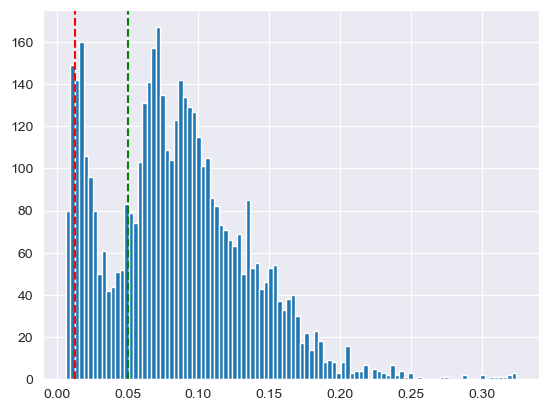

In [23]:
std_all = stds.droplevel(0)
std_all.hist(bins=100)
std_all.dropna(inplace=True)

print("The 5% quantile of the standard deviation of the correlation coefficient distribution is:", std_all.quantile(0.05))

print("The 25% quantile of the standard deviation of the correlation coefficient distribution is:", std_all.quantile(0.25))

plt.axvline(std_all.quantile(0.05), color='r', linestyle='--', label='5% Quantile')
plt.axvline(std_all.quantile(0.25), color='g', linestyle='--', label='25% Quantile')

In [24]:
stds[stds < stds.quantile(0.25)].groupby(level=0).count()

PC1    942
PC2     74
PC3     15
PC4     27
PC5    120
dtype: int64

In [25]:
# weighted standard deviation of correlation coefficients
def weighted_std(values, weights):
    values = np.array(values)
    weights = np.array(weights)
    
    weighted_mean = np.average(values, weights=weights)
    weighted_variance = np.average((values - weighted_mean) ** 2, weights=weights)    
    return np.sqrt(weighted_variance)

first_quarter_stds = stds[stds < stds.quantile(0.25)]

weights = first_quarter_stds.groupby(level=0).count()/len(first_quarter_stds)

weights

PC1    0.799660
PC2    0.062818
PC3    0.012733
PC4    0.022920
PC5    0.101868
dtype: float64

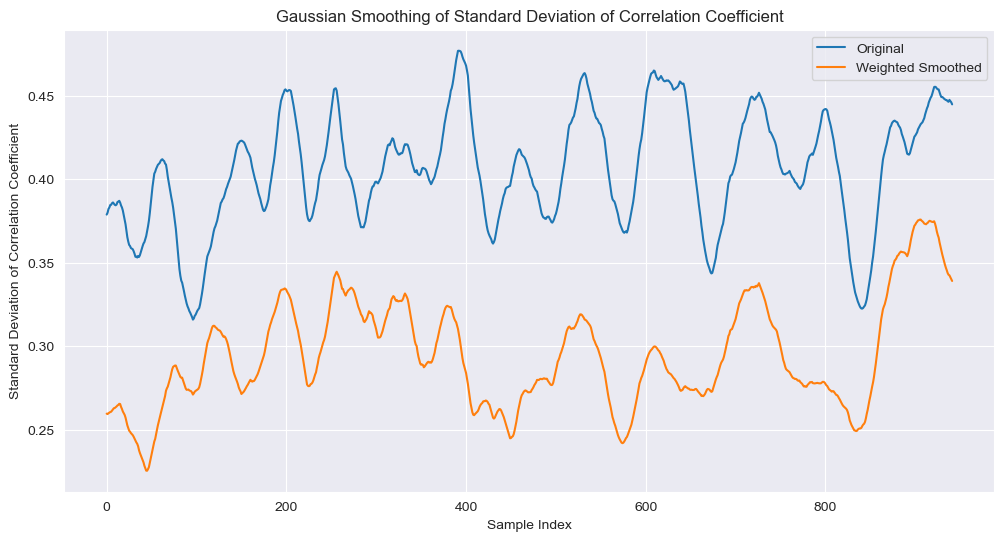

In [26]:
series = rolling_corr(target_w_pc, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).std(axis=1).rolling(30).mean()

linear_quartile_series = rolling_corr(target_w_pc, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).apply(lambda x: weighted_std(x, weights), axis=1).rolling(30).mean()

series.dropna(inplace=True)
series.reset_index(drop=True, inplace=True)

linear_quartile_series.dropna(inplace=True)
linear_quartile_series.reset_index(drop=True, inplace=True)

# plot the original and smoothed series
plt.figure(figsize=(12, 6))
plt.plot(series, label='Original')
plt.plot(linear_quartile_series, label='Weighted Smoothed')

plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Standard Deviation of Correlation Coefficient')
plt.title('Gaussian Smoothing of Standard Deviation of Correlation Coefficient')
plt.show()


In [27]:
# reduction on standard deviation of correlation coefficient of PCs
abs(series - linear_quartile_series).mean(), abs(series - linear_quartile_series).std()

(0.11136290203803846, 0.03215546535845509)

<Axes: >

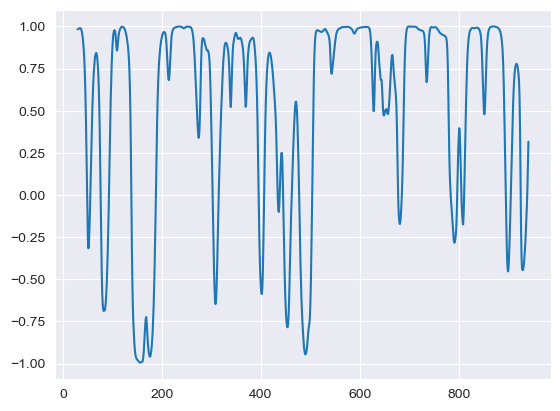

In [28]:
# rolling correlation coefficient of two series
series.rolling(30).corr(linear_quartile_series).plot()

# Higher Correlation Test Feature Case

Now, let's consider a case where the test feature has a higher correlation with the principal components.

The test feature is generated as follows:
$$F_{\text{test}} = F_1 + F_4$$

In [29]:
test_feature_high = data @ [1, 0, 0, 1, 0]

In [30]:
target_w_pc_high = pca_df.copy()
target_w_pc_high['Test Feature'] = test_feature_high

In [31]:
rolling_corr_series_high = rolling_corr(target_w_pc_high, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1)

<Axes: >

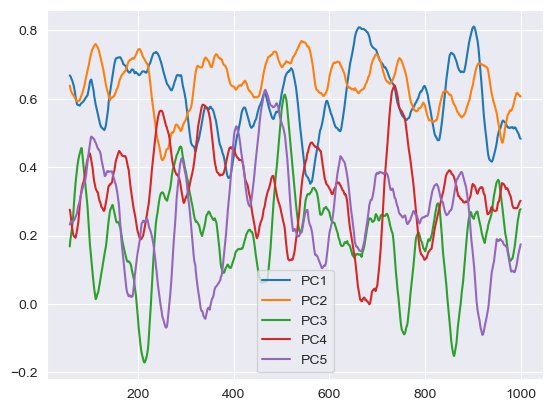

In [32]:
rolling_corr_series_high.rolling(30).mean().plot()

In [33]:
stds_high = rolling_corr_series_high.rolling(30).std().unstack()

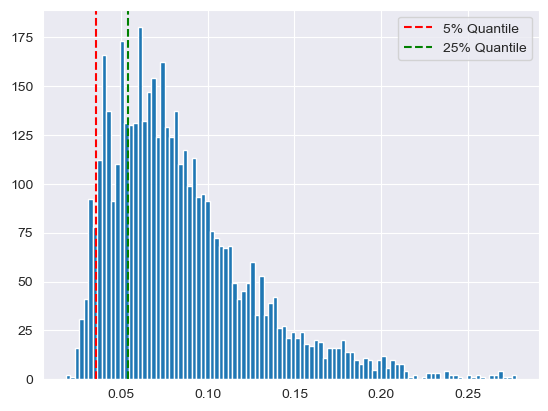

In [34]:
std_all_high = stds_high.droplevel(0)
std_all_high.hist(bins=100)
std_all_high.dropna(inplace=True)

# Add vertical line for the 5% and 25% quantile
plt.axvline(std_all_high.quantile(0.05), color='r', linestyle='--', label='5% Quantile')
plt.axvline(std_all_high.quantile(0.25), color='g', linestyle='--', label='25% Quantile')
plt.legend()

In [35]:
first_quarter_stds_high = stds_high[stds_high < stds_high.quantile(0.25)]
weights_high = first_quarter_stds_high.groupby(level=0).count()/len(first_quarter_stds_high)
weights_high.name = '25% Quantile Weights'

In [36]:
first_quarter_stds_high = stds_high[stds_high < stds_high.quantile(0.05)]
weights_high_5 = first_quarter_stds_high.groupby(level=0).count()/len(first_quarter_stds_high)
weights_high_5.name = '5% Quantile Weights'

weight_df_case2 = pd.concat([weights_high, weights_high_5], axis=1)
weight_df_case2

,25% Quantile Weights,5% Quantile Weights
PC1,0.314941,0.394068
PC2,0.447368,0.508475
PC3,0.065365,0.025424
PC4,0.101019,0.046610
PC5,0.071307,0.025424


We know there should be two equal weighted PCs that are highly correlated with the test feature, as the test feature is generated from Feature1 and Feature4, which seems to be captured by the first two PCs.

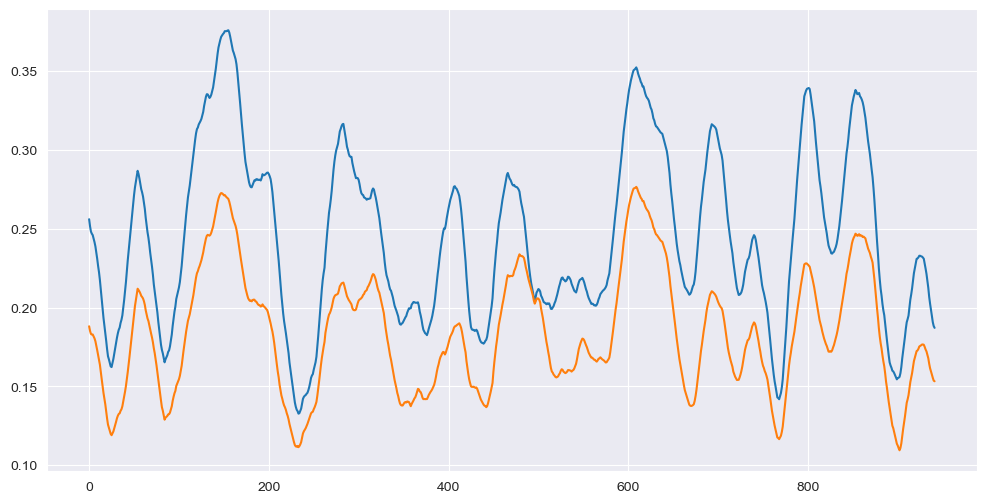

In [37]:
series_high = rolling_corr(target_w_pc_high, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).std(axis=1).rolling(30).mean()
linear_quartile_series_high = rolling_corr(target_w_pc_high, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).apply(lambda x: weighted_std(x, weights_high), axis=1).rolling(30).mean()

series_high.dropna(inplace=True)
series_high.reset_index(drop=True, inplace=True)

linear_quartile_series_high.dropna(inplace=True)
linear_quartile_series_high.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(series_high, label='Original')
plt.plot(linear_quartile_series_high, label='Weighted Smoothed')


In [38]:
# reduction on standard deviation of correlation coefficient of PCs
abs(series_high - linear_quartile_series_high).mean(), abs(series_high - linear_quartile_series_high).std()

(0.06104059311133381, 0.022748401582708418)

<Axes: >

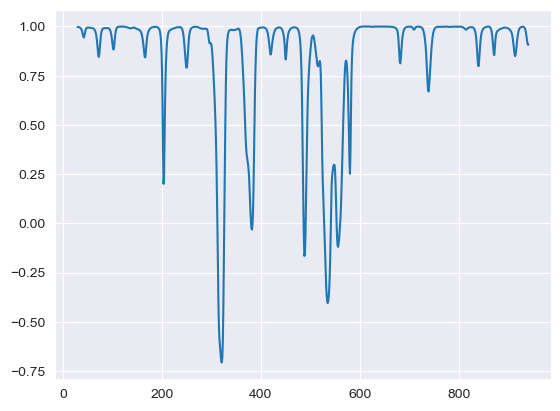

In [39]:
# rolling correlation coefficient of two series
series_high.rolling(30).corr(linear_quartile_series_high).plot()

Comparing to the previous case, two series (before weighted reduction and after weighted reduction) are more correlated in this case, which indicates the weighted reduction technique is less effective in this case as expected since the there are more PCs are contributing to the test feature (especially PC1 and PC2 which are equally contributing).

<Axes: >

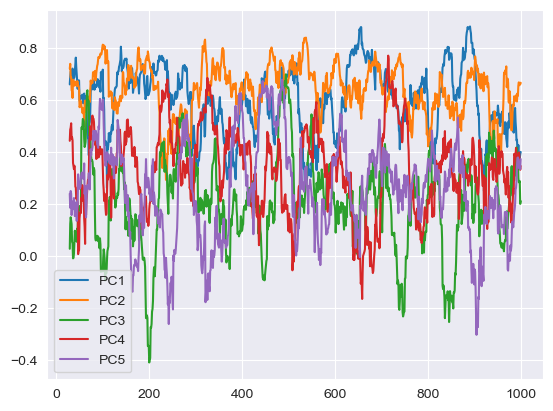

In [40]:
rolling_corr(target_w_pc_high, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).plot()

What does filtered sequence look like?

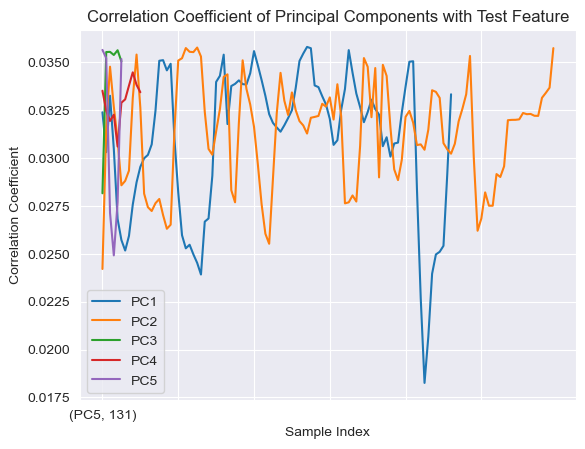

In [41]:
first_quarter_stds_high.groupby(level=0).plot()

plt.legend(target_w_pc_high.columns)
plt.xlabel('Sample Index')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient of Principal Components with Test Feature')
plt.show()

# Five-PC Case

Now, let's consider a case where we have a test feature five equally contributed principal components.

In [42]:
test_feature_five = data @ [-1.5, 0, 1, 0, 1]

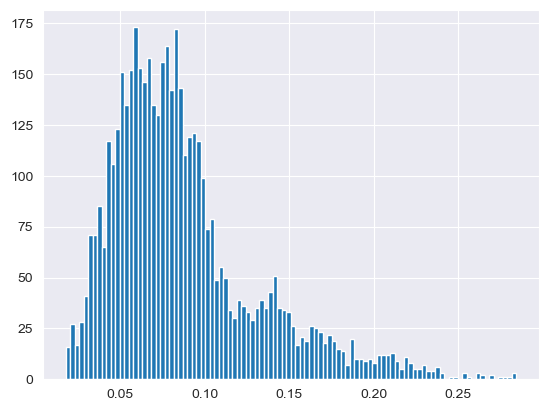

In [43]:
target_w_pc_five = pca_df.copy()
target_w_pc_five['Test Feature'] = test_feature_five

rolling_corr_series_five = rolling_corr(target_w_pc_five, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1)

stds_five = rolling_corr_series_five.rolling(30).std().unstack()
std_all_five = stds_five.droplevel(0)
std_all_five.hist(bins=100)
std_all_five.dropna(inplace=True)


In [44]:
first_quarter_stds_five = stds_five[stds_five < stds_five.quantile(0.25)]
weights_five = first_quarter_stds_five.groupby(level=0).count()/len(first_quarter_stds_five)

In [45]:
weights_five

PC1    0.322581
PC2    0.313243
PC3    0.124788
PC4    0.130730
PC5    0.108659
dtype: float64

Text(0.5, 0, 'Sample Index')

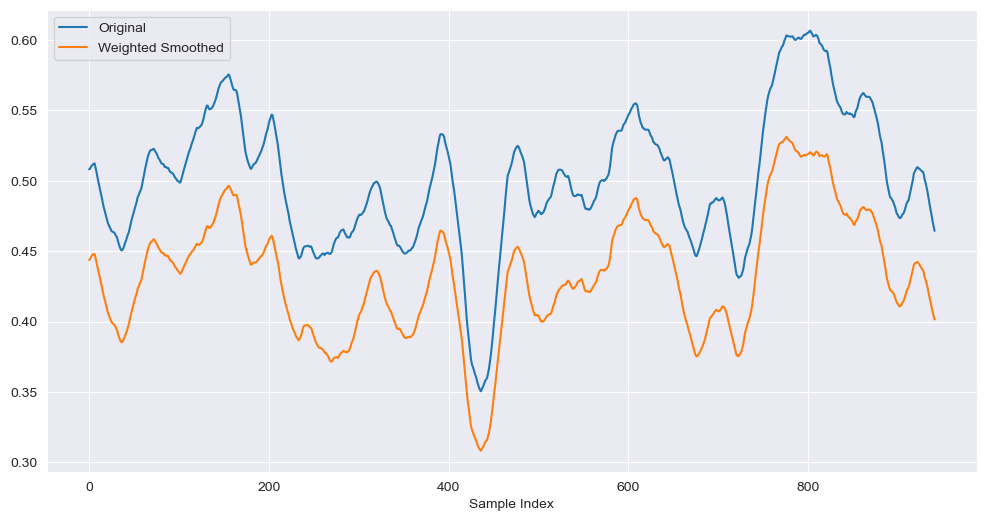

In [46]:
series_five = rolling_corr(target_w_pc_five, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).std(axis=1).rolling(30).mean()
linear_quartile_series_five = rolling_corr(target_w_pc_five, window=30)['Test Feature'].unstack().drop('Test Feature', axis=1).apply(lambda x: weighted_std(x, weights_five), axis=1).rolling(30).mean()

series_five.dropna(inplace=True)
series_five.reset_index(drop=True, inplace=True)

linear_quartile_series_five.dropna(inplace=True)
linear_quartile_series_five.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(series_five, label='Original')

plt.plot(linear_quartile_series_five, label='Weighted Smoothed')
plt.legend()
plt.xlabel('Sample Index')



In [47]:
# reduction on standard deviation of correlation coefficient of PCs
abs(series_five - linear_quartile_series_five).mean(), abs(series_five - linear_quartile_series_five).std()

(0.06814813566502508, 0.00913434110909952)

<Axes: >

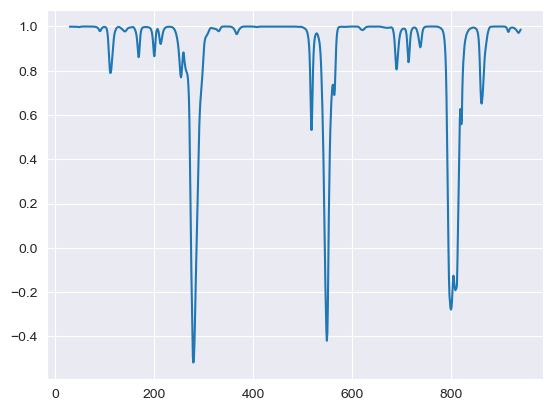

In [48]:
# rolling correlation coefficient of two series
series_five.rolling(30).corr(linear_quartile_series_five).plot()

Two series are even higher correlated in this case, that is the reduction technique is even less effective in changing the information embedded. 

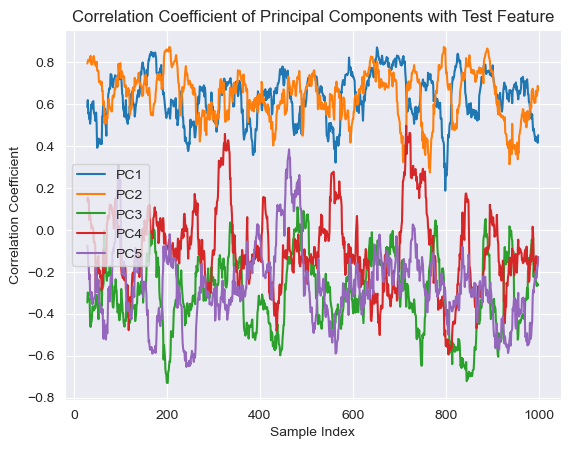

In [49]:
rolling_corr_series_five.plot()
plt.xlabel('Sample Index')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient of Principal Components with Test Feature')
plt.show()

What does filtered sequence look like?

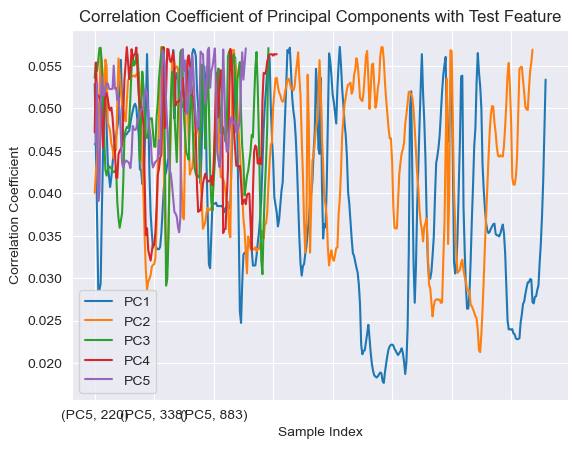

In [50]:
first_quarter_stds_five.groupby(level=0).plot()

plt.legend(target_w_pc_five.columns)
plt.xlabel('Sample Index')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient of Principal Components with Test Feature')
plt.show()

# Result Table

In [51]:
# Create a table to summarize the results

results = {
    'Case': ['Case 1', 'Case 2', 'Case 3'],
    'Mean Reduction': [abs(series - linear_quartile_series).mean(), abs(series_high - linear_quartile_series_high).mean(), abs(series_five - linear_quartile_series_five).mean()],
    'Std Reduction': [abs(series - linear_quartile_series).std(), abs(series_high - linear_quartile_series_high).std(), abs(series_five - linear_quartile_series_five).std()]
}

results_df = pd.DataFrame(results)
results_df

,Case,Mean Reduction,Std Reduction
0,Case 1,0.111363,0.032155
1,Case 2,0.061041,0.022748
2,Case 3,0.068148,0.009134


# Conclusion

Based on the dataset and result, the observation of the stability time-series of rolling coefficient of principal components with the target feature (measured in the rolling standard deviation) can be applied with quantile method in distribution to reduce the deviation. If the convergence of the correlation coefficient can be extracted as signal, quantile method can be used for robustness. 